# 3. Creación de GTFS específico para el sistema metro

Librerías a utilizar

In [1]:
import os
import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd

Lectura de archivos GTFS

In [2]:
PATH = "../"
data_path = os.path.join(PATH, 'data')
data_files = os.listdir(data_path)

dataframes : dict[pd.DataFrame] = {}
for file in data_files:
    if file.endswith(".txt"):
        datafile_fullpath = os.path.join(data_path, file)
        dataframes[file.split(".")[0]] = pd.read_csv(datafile_fullpath)

Capturamos todas la rutas que sean exclusivamente al sistema metro

In [3]:
list_metro_routes = dataframes["routes"][dataframes["routes"]["agency_id"] == "METRO"]["route_id"].to_list()
list_metro_routes

['CMX0200LB',
 'CMX0200LA',
 'CMX0200L9',
 'CMX0200L8',
 'CMX0200L7',
 'CMX0200L6',
 'CMX0200L5',
 'CMX0200L4',
 'CMX0200L3',
 'CMX0200L2',
 'CMX0200L1',
 'CMX020L12']

Capturamos las rutas y sus colores hexadecimales correspondientes

In [4]:
df_metro_routeid_colors = dataframes["routes"][["route_id", "route_color"]][dataframes["routes"]["route_id"].isin(list_metro_routes)]
df_metro_routeid_colors

,route_id,route_color
52,CMX0200LB,118751
53,CMX0200LA,A02D96
54,CMX0200L9,512826
55,CMX0200L8,118749
56,CMX0200L7,E87511
57,CMX0200L6,D81E05
58,CMX0200L5,F9D616
59,CMX0200L4,7FBCAA
60,CMX0200L3,AD9B0C
61,CMX0200L2,0071C1


## Filtrando ```trips.txt```

Filtramos los viajes que contengan a las rutas halladas del metro

In [5]:
index_metro_trips = dataframes["trips"].isin(list_metro_routes).any(axis = 1)

Obtenemos el dataframe asociado a los viajes (trips)

In [6]:
df_metro_trips = dataframes["trips"][index_metro_trips]
df_metro_trips.to_csv("../output_metro/trips_metro.csv", index = False)
df_metro_trips

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
230,CMX0200L2,3,02300L2000_1,Cuatro Caminos,Línea 2 to Cuatro Caminos,1,SH0200L2000_1
231,CMX0200L2,3,02300L2000_0,Tasqueña,Línea 2 to Tasqueña,0,SH0200L2000_0
232,CMX0200L2,2,02200L2000_1,Cuatro Caminos,Línea 2 to Cuatro Caminos,1,SH0200L2000_1
233,CMX0200L2,2,02200L2000_0,Tasqueña,Línea 2 to Tasqueña,0,SH0200L2000_0
234,CMX0200L2,1,02100L2000_1,Cuatro Caminos,Línea 2 to Cuatro Caminos,1,SH0200L2000_1
...,...,...,...,...,...,...,...
819,CMX020L12,3,0230L12000_0,Tláhuac,to Tláhuac,0,SH020L12000_0
820,CMX020L12,2,0220L12000_1,Mixcoac,to Mixcoac,1,SH020L12000_1
821,CMX020L12,2,0220L12000_0,Tláhuac,to Tláhuac,0,SH020L12000_0
822,CMX020L12,1,0210L12000_1,Mixcoac,to Mixcoac,1,SH020L12000_1


## Filtrando ```shapes.txt```

Obtenemos el dataframe asociado al trazo en el mapa de las rutas (shapes)

In [7]:
list_metro_shapes = df_metro_trips["shape_id"].to_list()
index_metro_shapes = dataframes["shapes"].isin(list_metro_shapes).any(axis = 1)

df_metro_shapes = dataframes["shapes"][index_metro_shapes]
df_metro_shapes.to_csv("../output_metro/shapes_metro.csv", index = False)
df_metro_shapes

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
31907,SH0200L2000_0,19.459593,-99.215842,1,0.00
31908,SH0200L2000_0,19.459988,-99.215853,2,0.04
31909,SH0200L2000_0,19.461953,-99.215781,3,0.26
31910,SH0200L2000_0,19.462163,-99.215747,4,0.28
31911,SH0200L2000_0,19.462329,-99.215687,5,0.30
...,...,...,...,...,...
49431,SH020L12000_1,19.374741,-99.183300,384,23.59
49432,SH020L12000_1,19.375058,-99.184339,385,23.70
49433,SH020L12000_1,19.375189,-99.184795,386,23.75
49434,SH020L12000_1,19.375265,-99.185108,387,23.78


In [8]:
df_metro_shapes['geometry'] = [Point(row['shape_pt_lon'], row['shape_pt_lat']) for _, row in df_metro_shapes.iterrows()]

shape_groups = df_metro_shapes.groupby('shape_id')
line_strings_map = [LineString(group['geometry'].tolist()) for _, group in shape_groups]

shapes_trips_df = gpd.GeoDataFrame({'shape_id': df_metro_shapes['shape_id'].unique()}, geometry=line_strings_map)

/tmp/ipykernel_10891/3089818538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metro_shapes['geometry'] = [Point(row['shape_pt_lon'], row['shape_pt_lat']) for _, row in df_metro_shapes.iterrows()]


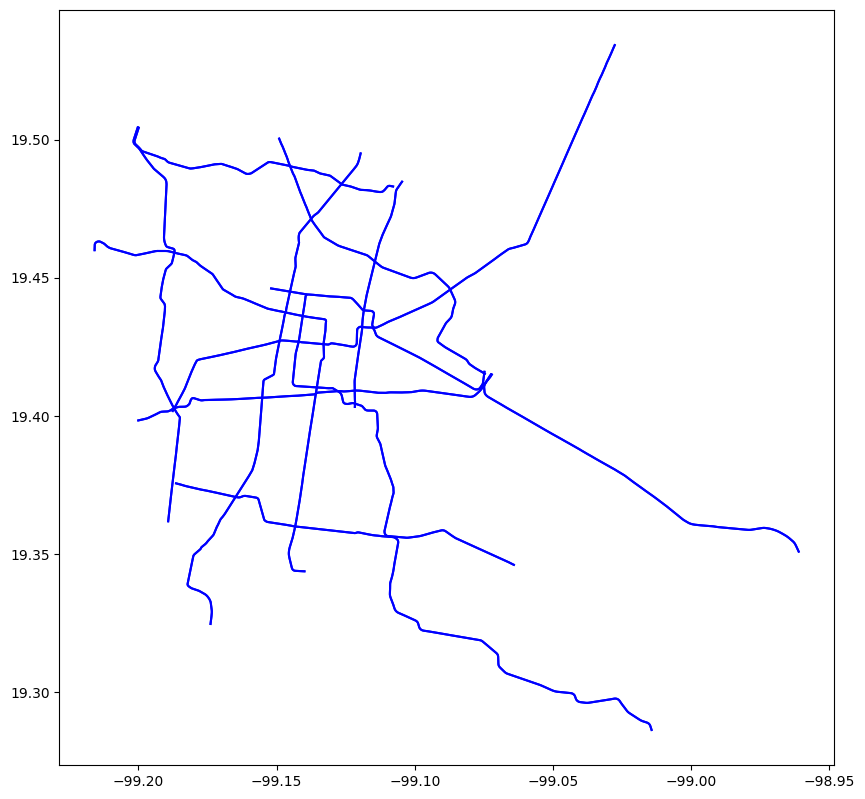

In [9]:
base_map = shapes_trips_df.plot(color = "blue", figsize=(10,10), zorder = 0)

## Filtrando ```stop_times.txt```

Capturamos los datos de tiempos de paradas asociados a las rutas del metro

In [10]:
list_metro_stoptimes = df_metro_trips["trip_id"].to_list()
index_metro_stoptimes = dataframes["stop_times"].isin(list_metro_stoptimes).any(axis = 1)

df_metro_stoptimes = dataframes["stop_times"][index_metro_stoptimes]
df_metro_stoptimes.to_csv("../output_metro/stop_times_metro.csv", index = False)
df_metro_stoptimes

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint
12674,02100L1000_0,00:00:00,00:00:00,0200L1-OBSERVATORIO,1,0
12675,02100L1000_0,00:02:50,00:02:50,0200L1-TACUBAYA,2,0
12676,02100L1000_0,00:05:24,00:05:24,0200L1-JUANACATLAN,3,0
12677,02100L1000_0,00:07:36,00:07:36,0200L1-CHAPULTEPEC,4,0
12678,02100L1000_0,00:08:43,00:08:43,0200L1-SEVILLA,5,0
...,...,...,...,...,...,...
13839,0230L12000_1,00:47:38,00:47:38,020L12-PARQUEVENADOS,16,0
13840,0230L12000_1,00:49:18,00:49:18,020L12-ZAPATA,17,0
13841,0230L12000_1,00:50:35,00:50:35,020L12-HOSPITAL20,18,0
13842,0230L12000_1,00:52:23,00:52:23,020L12-INSURGENTESSUR,19,0


## Filtrando ```stops.txt```

Dados los tiempos de las paradas exclusivas del sistema metro, se capturan los ```stop_id``` de cada parada presente

In [11]:
metro_id_stations = list(df_metro_stoptimes["stop_id"].unique())
index_metro_stations = dataframes["stops"].isin(metro_id_stations).any(axis = 1)

df_metro_stops = dataframes["stops"][index_metro_stations]
df_metro_stops.to_csv("../output_metro/stops_metro.csv", index = False)
df_metro_stops

,stop_id,stop_name,stop_lat,stop_lon,zone_id,wheelchair_boarding
3243,020L12-TLAHUAC,Tláhuac,19.28602,-99.01420,020L12-TLAHUAC,1
3244,020L12-TLALTENCO,Tlaltenco,19.29435,-99.02403,020L12-TLALTENCO,1
3245,020L12-ZAPOTITLAN,Zapotitlán,19.29666,-99.03431,020L12-ZAPOTITLAN,1
3246,020L12-NOPALERA,Nopalera,19.29996,-99.04599,020L12-NOPALERA,1
3247,020L12-OLIVOS,Olivos,19.30432,-99.05951,020L12-OLIVOS,1
...,...,...,...,...,...,...
3433,0200L1-SEVILLA,Sevilla,19.42185,-99.17112,0200L1-SEVILLA,1
3434,0200L1-CHAPULTEPEC,Chapultepec,19.42075,-99.17642,0200L1-CHAPULTEPEC,2
3435,0200L1-JUANACATLAN,Juanacatlán,19.41295,-99.18198,0200L1-JUANACATLAN,2
3436,0200L1-TACUBAYA,Tacubaya,19.40251,-99.18764,0200L1-TACUBAYA,2


<Axes: >

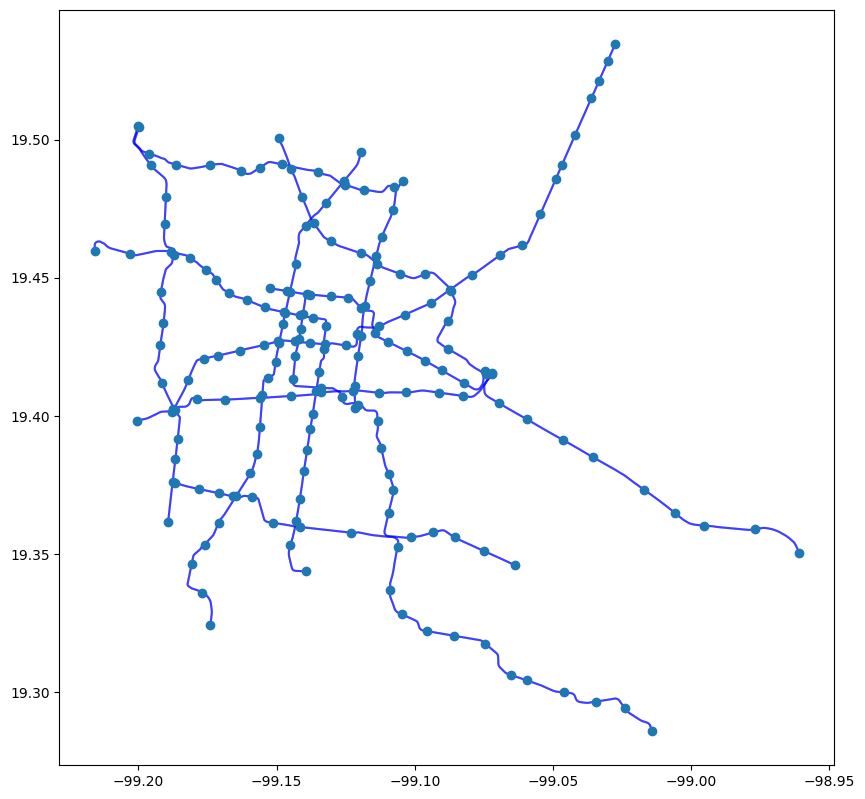

In [12]:
base_map = shapes_trips_df.plot(color = "blue", alpha = 0.5, figsize=(10,10), zorder = 0)

base_map.scatter(df_metro_stops["stop_lon"], df_metro_stops["stop_lat"])
base_map

## Filtrando ```frequencies.txt```

Y finalmente, se filtran los datos de las frecuencias dadas las etiquetas de los viajes registrados

In [13]:
metro_trips_id = list(df_metro_trips["trip_id"].unique())

index_metro_frequencies = dataframes["frequencies"].isin(metro_trips_id).any(axis = 1)
df_metro_frequencies = dataframes["frequencies"][index_metro_frequencies]
df_metro_frequencies.to_csv("../output_metro/frequencies_metro.csv", index = False)
df_metro_frequencies

,trip_id,start_time,end_time,headway_secs,exact_times
547,02300LB000_1,7:00:00,24:00:00,180,0
548,02300LB000_0,7:00:00,24:00:00,180,0
549,02200LB000_1,6:00:00,24:00:00,180,0
550,02200LB000_0,6:00:00,24:00:00,180,0
551,02100LB000_1,5:00:00,24:00:00,180,0
...,...,...,...,...,...
1519,02300L1000_0,7:00:00,24:00:00,240,0
1520,02200L1000_1,6:00:00,24:00:00,240,0
1521,02200L1000_0,6:00:00,24:00:00,240,0
1522,02100L1000_1,5:00:00,24:00:00,240,0
